# 0. Import library

In [1]:
import pickle
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup as bs
import re
from tqdm import tqdm 
import time
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# pd.options.display.float_format = '{:.2f}'.format

# 1. Load Data

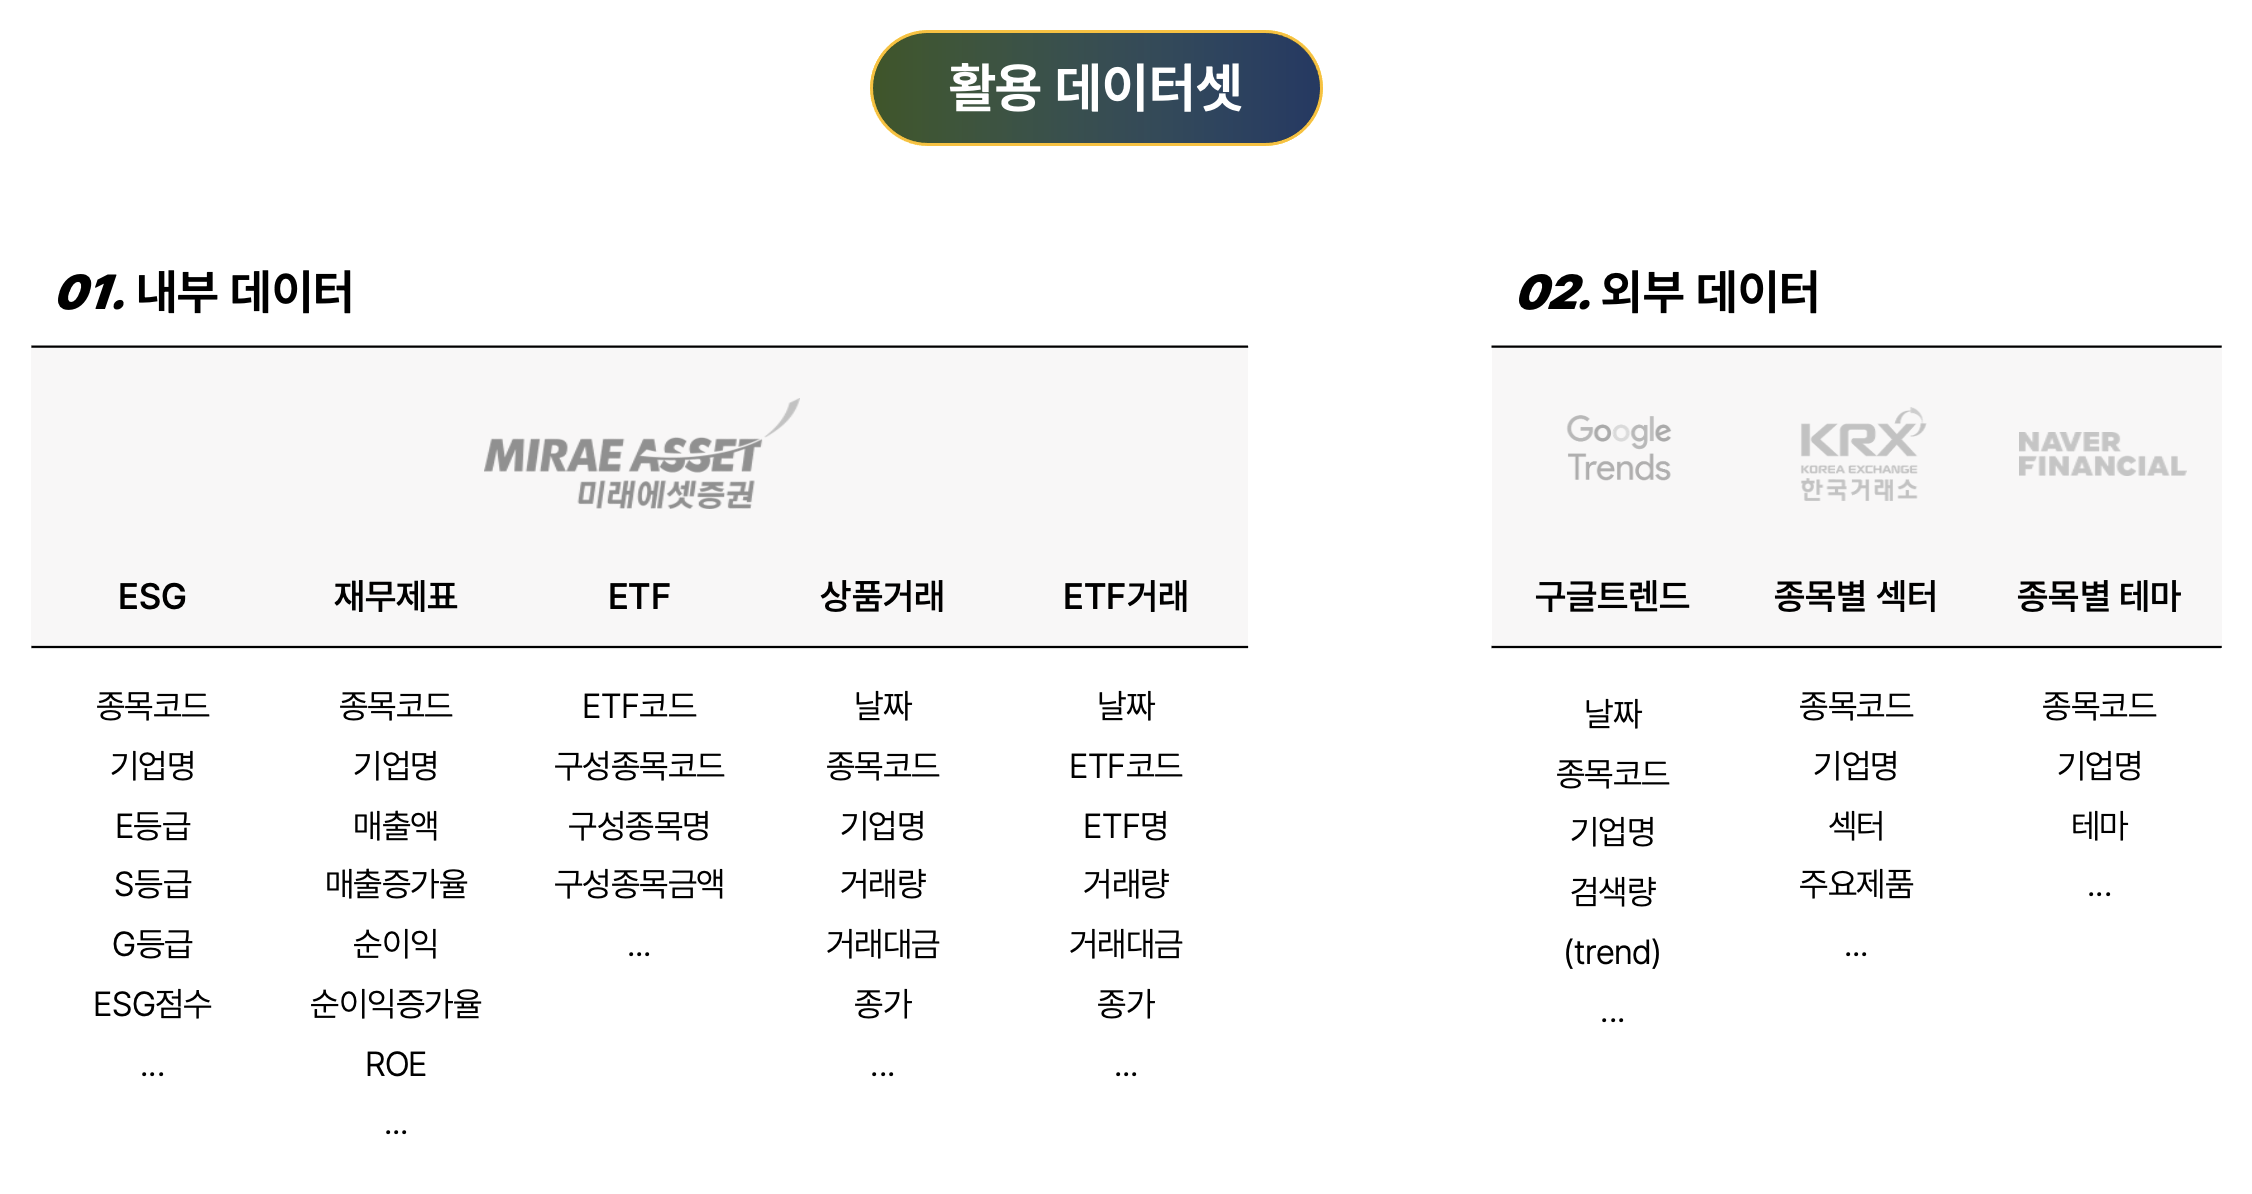

In [2]:
from IPython.display import Image
Image('활용데이터.png')

In [3]:
# 국내주식재무비율
with open("국내주식재무비율.pkl","rb") as fr:
    df_fin_rate = pickle.load(fr)

# 국내주식재무제표
with open("국내주식재무제표.pkl","rb") as fr:
    df_fin_num = pickle.load(fr)

# ESG (전체 / E / S / G / FG)
df_esg_info = pd.read_excel('ESG중분류_E,S,G(2021)_미래에셋증권.xlsx', header = 3, index_col = 0)

df_esg_e = pd.read_excel('ESG중분류_E,S,G(2021)_미래에셋증권.xlsx', sheet_name = 1, skiprows = 3, index_col = 0)
df_esg_e.reset_index(drop = True, inplace = True)

df_esg_s = pd.read_excel('ESG중분류_E,S,G(2021)_미래에셋증권.xlsx', sheet_name = 2, skiprows = 3, index_col = 0)
df_esg_s.reset_index(drop = True, inplace = True)

df_esg_g = pd.read_excel('ESG중분류_E,S,G(2021)_미래에셋증권.xlsx', sheet_name = 3, skiprows = 3, index_col = 0)
df_esg_g.reset_index(drop = True, inplace = True)

df_esg_fg = pd.read_excel('ESG중분류_E,S,G(2021)_미래에셋증권.xlsx', sheet_name = 4, skiprows = 3, index_col = 0)
df_esg_fg.reset_index(drop = True, inplace = True)

# ETF
df_etf_info = pd.read_csv('etf_info.csv')

# 업종
df_industry = pd.read_csv('종목_업종_테이블.csv')

# ETF 거래
df_etf_trade = pd.read_csv('국내ETF_2021_4분기_거래량_거래대금.csv')

# 주식 거래
df_stock_trade = pd.read_csv('국내상품_2021_12월_거래량_거래대금.csv')

# 2. Data Pre-Processing

> **2-1. 전체 데이터 공백 제거**<br><br>
> **2-2. ESG Data 전처리**<br>
> 2-2-1. 필요 column 추출 등 DataFrame 생성<br>
> 2-2-2. 종목별 섹터 데이터 크롤링 (외부 데이터)<br>
> 2-2-3. 섹터(동종업계) 내 ESG 점수(순위) 산정<br><br>
> **2-3. ETF Data 전처리**<br>
> 2-3-1. 필요 column 추출, ratio 계산 등 DataFrame 생성<br>
> 2-3-2. ETF ESG 점수 도출<br><br>
> **2-4. 재무제표 Data 전처리**<br>
> 2-4-1. 필요 column 추출 등 DataFrame 생성<br><br>
> **2-5. 업종 Data 전처리**<br>
> 2-5-1. 필요 column 추출 등 DataFrame 생성<br><br>
> **2-6. 네이버증권 테마 Data 크롤링 (외부 데이터)**<br><br>
> **2-7. 구글트렌드 Data 크롤링 및 전처리**<br><br>
> **2-8. ETF 거래 Data 전처리**<br>
> 2-8-1. 필요 column 추출 등 DataFrame 생성<br><br>
> **2-9. 상품 거래 Data 전처리**<br>
> 2-9-1. 필요 column 추출 등 DataFrame 생성

### 2-1. 전체 데이터 공백 제거

In [6]:
# 공백제거 함수 정의
def nospace(df):
  for i in range(len(df.columns)):
    df.iloc[:,i] = df.iloc[:,i].astype(str).str.replace(" ","")

# 데이터 공백 제거
nospace(df_fin_rate)
nospace(df_fin_num)
nospace(df_etf_info)
nospace(df_industry)
nospace(df_etf_trade)
nospace(df_stock_trade)

### 2-2. ESG Data 전처리

In [7]:
# FG데이터 전처리
df_esg_fg_no = df_esg_fg[df_esg_fg['상장된 시장'] != 'EX']
df_esg_fg_no.rename(columns={'FG.감사기구 및\n내부통제':'FG.감사기구', 'FG.등급':'G.등급', 'FG.총점':'G.총점', 'FG.주주권리보호':'G.주주권리보호', 'FG.이사회':'G.이사회', 'FG.공시':'G.공시', 'FG.감사기구 및\n내부통제':'G.감사기구', 'FG.감점':'G.감점'}, inplace=True)
df_esg_fg_no = df_esg_fg_no[['Code', 'Name', '법인등록번호', '결산월', '상장된 시장', 'G.등급', 'G.총점', 'G.주주권리보호', 'G.이사회', 'G.공시', 'G.감사기구', 'G.감점']]
df_esg_g_final = pd.concat([df_esg_g, df_esg_fg_no])
df_esg_g = df_esg_g_final

# ESG 정기총점 추출
df_esg_total = df_esg_info[['Code', 'ESG.정기총점']]

# 데이터 병합
merge1 = pd.merge(df_esg_e, df_esg_s, on='Code', how='inner',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
merge2 = pd.merge(merge1, df_esg_g, on='Code', how='inner',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
merge3 = pd.merge(merge2, df_esg_total, on='Code', how='inner',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

# 불필요한 column 삭제
merge3.drop(columns = ['법인등록번호', '결산월'], inplace=True)
df_esg = merge3

# column명 변경
df_esg.rename(columns = {'E.등급':'E등급', 'S.등급':'S등급', 'G.등급':'G등급'}, inplace = True)

# 기업명 공백제거
df_esg.Name = df_esg.Name.astype(str).str.replace(" ", "")

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [8]:
# 종목별 섹터 데이터 크롤링 (외부 데이터)
df_product = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
 
df_product.종목코드 = df_product.종목코드.map("{:06d}".format)
df_product = df_product[['종목코드', '회사명', '업종', '주요제품']]
df_product = df_product.rename(columns={'종목코드':'code', '회사명':'name', '업종':'industry', '주요제품':'main_product'})
df_product['code'] = 'A' + df_product['code'].str[:]
df_product

,code,name,industry,main_product
0,A000210,DL,기타 금융업,지주회사
1,A004840,DRB동일,고무제품 제조업,"고무벨트(V벨트,콘베이어벨트,평벨트),프라스틱제품 제조,판매"
2,A155660,DSR,1차 비철금속 제조업,합섬섬유로프
3,A078930,GS,기타 금융업,지주회사/부동산 임대
4,A001250,GS글로벌,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서..."
...,...,...,...,...
2488,A393210,토마토시스템,소프트웨어 개발 및 공급업,UI솔루션
2489,A217880,틸론,소프트웨어 개발 및 공급업,"Cloud Solution (D,A,E,Rstation)"
2490,A222670,플럼라인생명과학,자연과학 및 공학 연구개발업,"강아지암치료제,돼지DNA테라피"
2491,A331660,한국미라클피플사,기타 화학제품 제조업,"은나노스텝, 닥터오렌지 등"


In [9]:
# 섹터 내 ESG 점수(순위) 산정
# ESG 데이터와 섹터 데이터 병합
df_sector_score = pd.merge(df_esg, df_product, left_on='Code', right_on='code', how='inner')
df_sector_score.drop(columns=['code', 'name', 'main_product'], inplace=True)

# 섹터별 E, S, G, ESG 순위 부여
df_sector_score['E_rank'] = df_sector_score.groupby('industry')['E.총점'].rank(method = 'min', ascending=False)
df_sector_score['S_rank'] = df_sector_score.groupby('industry')['S.총점'].rank(method = 'min', ascending=False)
df_sector_score['G_rank'] = df_sector_score.groupby('industry')['G.총점'].rank(method = 'min', ascending=False)
df_sector_score['ESG_rank'] = df_sector_score.groupby('industry')['ESG.정기총점'].rank(method = 'min', ascending=False)

# 섹터별 E, S, G, ESG 평균 총점
df_sector_mean = pd.DataFrame(df_sector_score.groupby('industry').mean())
df_sector_mean.reset_index(inplace=True)

df_sector_mean.rename(columns={'E.총점':'평균 E총점', 'S.총점':'평균 S총점', 'G.총점':'평균 G총점', 'ESG.정기총점':'평균 ESG총점'}, inplace=True)
df_sector_mean = df_sector_mean[['industry', '평균 E총점', '평균 S총점', '평균 G총점', '평균 ESG총점']]

# 섹터별 상위 E, S, G, ESG % 부여
df_sector_count = pd.DataFrame(df_sector_score.industry.value_counts())
df_sector_count.reset_index(inplace=True)
df_sector_count.rename(columns={'index':'industry', 'industry':'count'}, inplace=True)

df_esg_final = pd.merge(df_sector_score, df_sector_mean, on='industry', how='outer')
df_esg_final = pd.merge(df_esg_final, df_sector_count, on='industry', how='outer')

df_esg_final['상위 E%'] = df_esg_final['E_rank'] / df_esg_final['count'] * 100
df_esg_final['상위 S%'] = df_esg_final['S_rank'] / df_esg_final['count'] * 100
df_esg_final['상위 G%'] = df_esg_final['G_rank'] / df_esg_final['count'] * 100
df_esg_final['상위 ESG%'] = df_esg_final['ESG_rank'] / df_esg_final['count'] * 100

### 2-3. ETF Data 전처리

In [10]:
# 종목 CODE 있는 종목만 추출 (원화예금 등 index 지표를 빼기 위함)
df_etf = df_etf_info[df_etf_info.ETF_ITEM_CD != 'nan']

# ETF별 평가금액 합
df_etf['ETF_EA'] = df_etf['ETF_EA'].astype(float)
df_etf_sum = df_etf.groupby(['ETF_CD'], as_index=False).sum()
df_etf_notnull = pd.merge(df_etf, df_etf_sum[['ETF_CD','ETF_EA']], on='ETF_CD')

# ETF 구성종목 비율 계산
df_etf_notnull['ratio'] = df_etf_notnull['ETF_EA_x'] / df_etf_notnull['ETF_EA_y']
df_etf = df_etf_notnull[['ETF_CD', 'ETF_NM', 'ETF_ITEM_CD', 'ETF_CMST_ITM_NM', 'ETF_EA_x', 'ratio']]

<ipython-input-10-02be668b0425>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_etf['ETF_EA'] = df_etf['ETF_EA'].astype(float)


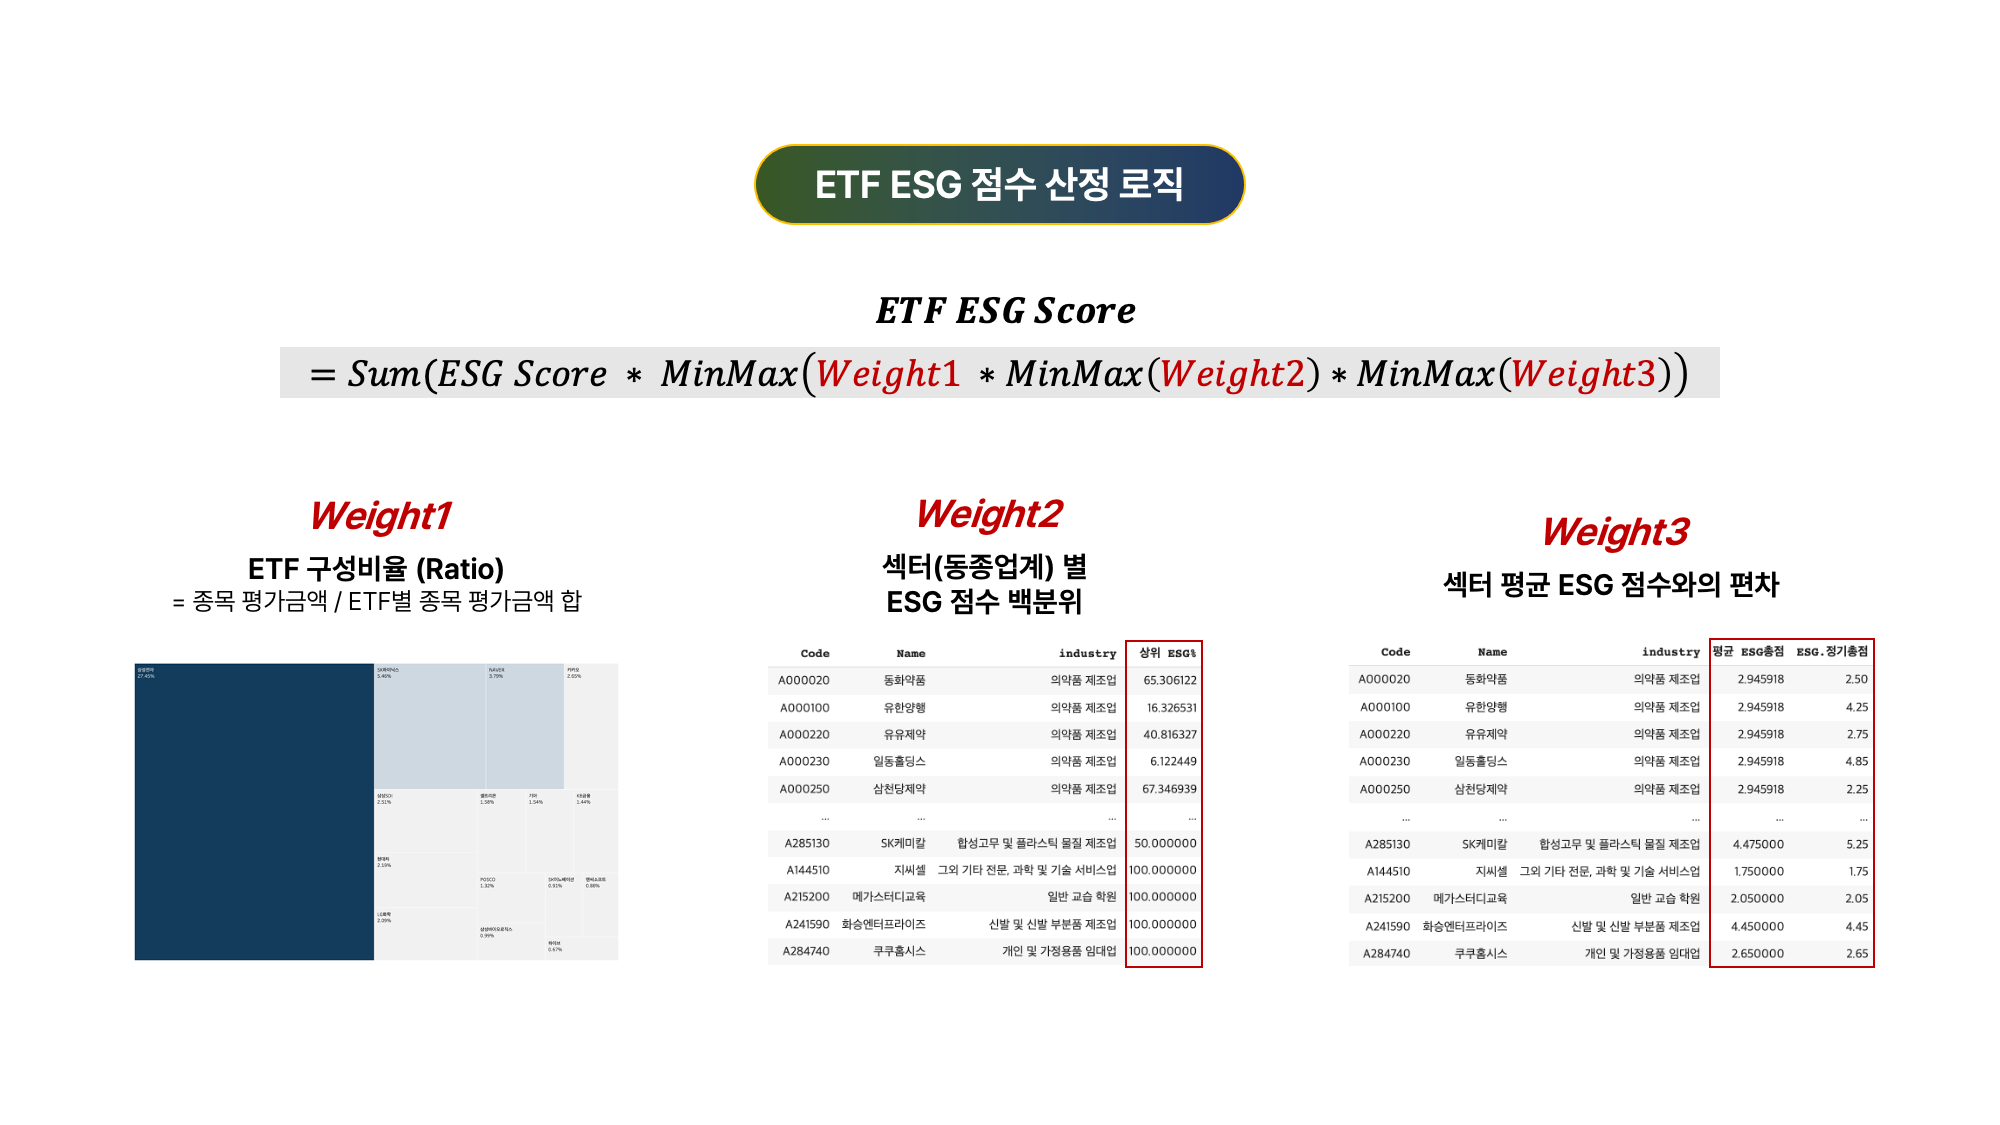

In [20]:
Image('esg.png')

In [11]:
# ETF의 ESG 점수 도출
# ETF, ESG 데이터 병합
df_esg_weight = df_esg_final[['Code', 'Name', 'ESG.정기총점', '평균 ESG총점', '상위 ESG%']]
etf_esg = pd.merge(df_etf, df_esg_weight, left_on='ETF_ITEM_CD', right_on='Code')


# 가중치 계산
# MinMax Scale (0~1)
etf_esg['weight1_ratio'] = etf_esg['ratio']
etf_esg['weight2_diff'] = etf_esg['ESG.정기총점'] - etf_esg['평균 ESG총점']
etf_esg['weight3_rank'] = 101 - etf_esg['상위 ESG%']
etf_esg_weight = etf_esg[['weight1_ratio', 'weight2_diff', 'weight3_rank']]

transformer = MinMaxScaler(feature_range=(0, 1))
transformer.fit(etf_esg_weight)
etf_esg_weight_scale = pd.DataFrame(transformer.transform(etf_esg_weight), columns=etf_esg_weight.columns)
etf_esg_weight_scale['weight'] = etf_esg_weight_scale['weight1_ratio'] * etf_esg_weight_scale['weight2_diff'] * etf_esg_weight_scale['weight3_rank']
etf_esg_weight_scale = etf_esg_weight_scale[['weight']]
transformer.fit(etf_esg_weight_scale)
etf_esg_weight_scale_final = pd.DataFrame(transformer.transform(etf_esg_weight_scale), columns=etf_esg_weight_scale.columns)
etf_esg['weight'] = etf_esg_weight_scale_final['weight']
etf_esg.drop(columns=['Code', 'Name', 'weight1_ratio', 'weight2_diff', 'weight3_rank'], inplace=True)


# 가중치를 고려한 ETF ESG 점수 계산
etf_esg['ESG_SCORE'] = etf_esg['ESG.정기총점'] * etf_esg['weight']

etf_esg_score = etf_esg.groupby(['ETF_CD'], as_index = False).sum()
etf_esg_score = etf_esg_score[['ETF_CD', 'ESG_SCORE']]
etf_esg = pd.merge(etf_esg, etf_esg_score, on = 'ETF_CD')

etf_esg.drop(columns=['ESG_SCORE_x'], inplace=True)
etf_esg.rename(columns={'ESG_SCORE_y':'ESG_SCORE'}, inplace=True)

### 2-4. 재무제표 Data 전처리

In [12]:
# 재무비율
df_fin1 = df_fin_rate[['CODE', 'DATA_TP_CODE', 'IFRS_TP_CODE', 'SET_TP_CODE', 'BASE_YM', 'CO_NM', 'SALE_GROW_RATE', 'PROFIT_GROW_RATE', 'ROE']]
df_fin1 = df_fin1[df_fin1['BASE_YM'].str.contains('2021')]
df_fin1 = df_fin1[df_fin1['DATA_TP_CODE'] == '1']
df_fin1 = df_fin1[df_fin1['IFRS_TP_CODE'] == 'B']
df_fin1.drop(df_fin1[df_fin1['SET_TP_CODE'] == '4'].index, inplace=True)
df_fin1.drop(['DATA_TP_CODE', 'IFRS_TP_CODE', 'BASE_YM'], axis=1, inplace=True)

# 재무제표
df_fin2 = df_fin_num[['CODE', 'DATA_TP_CODE', 'IFRS_TP_CODE', 'SET_TP_CODE', 'BASE_YM', 'CO_NM', 'SALE_AMT', 'THIS_TERM_PROFIT', 'BHJS_CNT']]
df_fin2 = df_fin2[df_fin2['BASE_YM'].str.contains('2021')]
df_fin2 = df_fin2[df_fin2['DATA_TP_CODE'] == '1']
df_fin2 = df_fin2[df_fin2['IFRS_TP_CODE'] == 'B']
df_fin2.drop(df_fin2[df_fin2['SET_TP_CODE'] == '4'].index, inplace=True)
df_fin2.drop(['DATA_TP_CODE', 'IFRS_TP_CODE', 'BASE_YM'], axis=1, inplace=True)

# 재무데이터 병합
df_fin = pd.merge(df_fin1, df_fin2, left_on=['CODE', 'SET_TP_CODE', 'CO_NM'], right_on=['CODE', 'SET_TP_CODE', 'CO_NM'], how='inner')
df_fin[['SALE_GROW_RATE', 'PROFIT_GROW_RATE', 'ROE', 'SALE_AMT', 'THIS_TERM_PROFIT', 'BHJS_CNT']] = df_fin[['SALE_GROW_RATE', 'PROFIT_GROW_RATE', 'ROE', 'SALE_AMT', 'THIS_TERM_PROFIT', 'BHJS_CNT']].astype(float)

### 2-5. 업종 Data 전처리

In [13]:
df_industry = df_industry[['종목코드', '종목명', '업종']]

### 2-6. 네이버증권 테마 데이터 크롤링 (외부 데이터)

In [14]:
# 각 테마 페이지별 테마명&주식종목명 가져오기
def one_page_list(page):
    STOCKLIST_URL = "https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no={}".format(page)
    
    response = urllib.request.urlopen(STOCKLIST_URL)
    STOCKLIST_HTML = response.read()
    
    soup = bs(STOCKLIST_HTML)

    STOCK_NAME_LIST = []
    STOCK_CODE_LIST = []
    THEME_NAME_LIST = []

    for tr in soup.findAll('td', attrs={'class', 'name'}):
        stockName = tr.findAll('a', attrs={})
        stockCode = re.findall('.+(?=")', str(tr.findAll('a', attrs={})))[0].split("code=")[1]
        if stockName is None or stockName == []:
            pass
        else:
            stockName = stockName[0].contents[-1]
            STOCK_NAME_LIST.append(stockName)
            STOCK_CODE_LIST.append(stockCode)

    for tr in soup.findAll('title'):
        themeName = tr
        if themeName is None or themeName == []:
            pass
        else:
            themeName = themeName.contents[-1]
            THEME_NAME_LIST.append(themeName)

    STOCK_LIST = []

    for i in range(len(STOCK_NAME_LIST)):
        stockInfo = [STOCK_CODE_LIST[i], STOCK_NAME_LIST[i], THEME_NAME_LIST[0]]
        STOCK_LIST.append(stockInfo)

    return pd.DataFrame(STOCK_LIST, columns=('코드', '종목명', '테마'))


theme_list = []
for i in tqdm([1,2,3,4,5,6,7]):
    url = "https://finance.naver.com/sise/theme.naver?&page={}".format(i)
    req = urllib.request.Request(url)
    sourcecode = urllib.request.urlopen(url).read()
    soup = bs(sourcecode, "html.parser")
    soup = soup.find_all("td", attrs={'class', "col_type1"})
    theme_list.extend(list(soup))

for i in range(0,len(theme_list)):
    theme_list[i] = theme_list[i].find("a")["href"]
    theme_list[i] = theme_list[i].replace('/sise/sise_group_detail.naver?type=theme&no=', '')


df_theme = pd.DataFrame()
for i in tqdm(theme_list):
    df_temp = one_page_list(i)
    df_theme = df_theme.append(df_temp)
    
for i in tqdm(range(0,len(df_theme))):
    df_theme.iloc[i]['테마'] = df_theme.iloc[i]['테마'].replace(' : 네이버 금융', '')

def make_code(x):
    x=str(x)
    return 'A'+ '0'*(6-len(x)) + x

df_theme['코드'] = df_theme['코드'].apply(make_code)
df_theme

100%|██████████| 6050/6050 [00:00<00:00, 6564.82it/s]


,코드,종목명,테마
0,A177830,파버나인,키오스크(KIOSK)
1,A089150,케이씨티,키오스크(KIOSK)
2,A052600,한네트,키오스크(KIOSK)
3,A063570,한국전자금융,키오스크(KIOSK)
4,A094940,푸른기술,키오스크(KIOSK)
...,...,...,...
1,A222810,마이더스AI,마리화나(대마)
2,A900100,애머릿지,마리화나(대마)
3,A052420,오성첨단소재,마리화나(대마)
4,A256840,한국비엔씨,마리화나(대마)


### 2-7. 구글트렌드 Data 전처리

In [ ]:
pip install pytrends

In [16]:
# pytrends 라이브러리
from pytrends.request import TrendReq
from tqdm import tqdm
from tqdm import trange

# 기업명 list 생성
stock_list = list(df_esg_final.Name)

# 크롤러 생성
trend_df = pd.DataFrame(columns=['Date', 'CO NM', 'Trend'])
period = 'today 1-m'

for i in trange(len(stock_list)):
    try:
        a = TrendReq()
        a.build_payload(kw_list=[stock_list[i]], timeframe=period, geo='KR')
        a_df = a.interest_over_time()
        data1 = {'Date' : a_df.index,
                 'CO NM' : a_df.columns[0],
                 'Trend' : a_df.iloc[:,0]}
        DF1 = pd.DataFrame(data1).reset_index(drop=True)
        trend_df = pd.concat([trend_df, DF1], ignore_index=True)
    except:
        pass

100%|██████████| 943/943 [29:52<00:00,  1.90s/it]


In [17]:
# DF에 종목코드 추가
Code_df = df_esg_final[['Code', 'Name']]
trend_code_df = pd.merge(trend_df, Code_df, left_on='CO NM', right_on='Name')

trend_code_df.drop(columns=['Name'], inplace=True)
trend_code_df.rename(columns={'Code':'CODE'}, inplace=True)

In [21]:
trend_code_df

,Date,CO NM,Trend,CODE
0,2022-01-21,동화약품,0,A000020
1,2022-01-22,동화약품,0,A000020
2,2022-01-23,동화약품,0,A000020
3,2022-01-24,동화약품,37,A000020
4,2022-01-25,동화약품,34,A000020
...,...,...,...,...
21985,2022-02-15,쿠쿠홈시스,0,A284740
21986,2022-02-16,쿠쿠홈시스,0,A284740
21987,2022-02-17,쿠쿠홈시스,100,A284740
21988,2022-02-18,쿠쿠홈시스,0,A284740


### 2-8. ETF 거래 Data 전처리

In [18]:
df_etf_trade = df_etf_trade[['DATA_DATE', '거래량', '거래대금', '종가', 'ITEM_S_CD', '한글명_F']]
df_etf_trade['DATA_DATE'] = df_etf_trade['DATA_DATE'].str[:8]
df_etf_trade[['거래량', '거래대금', '종가']] = df_etf_trade[['거래량', '거래대금', '종가']].astype(float)
df_etf_trade.rename(columns={'ITEM_S_CD':'ETF_CD'}, inplace=True)

### 2-9. 상품 거래 Data 전처리

In [19]:
stock_trade = df_stock_trade[['DATA_DATE', '거래량', '거래대금', '종가', 'ITEM_S_CD', '한글명_F']]
stock_trade['DATA_DATE'] = stock_trade['DATA_DATE'].str[:8]
stock_trade[['거래량', '거래대금', '종가']] = stock_trade[['거래량', '거래대금', '종가']].astype(float)
stock_trade.rename(columns={'ITEM_S_CD':'ITEM_CD'}, inplace=True)

<ipython-input-19-b47f7b5db5ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_trade['DATA_DATE'] = stock_trade['DATA_DATE'].str[:8]
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d